In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Definition

![Bild](img/ex66.png)

### Cliff- Example: 
* Episodic Task
* Simple Grid-World
* States are Grid-Positions
* Available actions are King-Moves
* Each step (not falling down the cliff) has a reward of R = -1
* Reaching the Goal has a reward of 0
* Walking down the cliff resets the position back to the start S with reward R = -100

### Note
* In the Pseudocode for n-step TD States and Rewards get stored in a Datastructure that takes their indexes $\% (n+1)$ - Right now I just store the whole sequence. Shouldn't be a difficult change, just put in some $\%$ operator everytime we access or store something.

In [2]:
class Cliff:
    '''Class defining the environment'''
    def __init__(self, shapex, shapey, holes, start, goal):
        self.shapex = shapex
        self.shapey = shapey
        self.holes  = holes
        self.start  = start
        self.goal   = goal
        
        self.bitmap = self.build_bitmap()
        
    def build_bitmap(self):
        '''builds the bitmap for visualisation'''
        bitmap = np.ones((self.shapex, self.shapey))
        
        for hole in holes:
            bitmap[hole] = 0
        
        return bitmap
    
    def show_bitmap(self):
        '''shows the environment of holes and walkable path'''
        
        plt.imshow(self.bitmap)
    
    def show_path(self, path):
        '''
        path : list(tuple(int, int)) : sequence of states
        
        plots a given path onto the bitmap
        '''
        
        c0 = 5
        c1 = 6
        
        length    = len(path)
        map_      = self.bitmap.copy()
        fade      = np.linspace(c0, c1, num=length)
        
        for i in range(length):
            map_[path[i]] = fade[i]
            
        map_[self.start] = c0
        map_[self.goal]  = c1
        
        print(f"path length: {len(path)}")
        plt.imshow(map_)

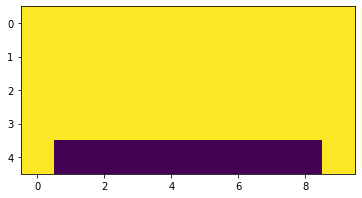

In [3]:
shapex = 5
shapey = 10
start  = (4, 0)
goal   = (4, 9)
holes  = [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8)]
#, (3, 5), (2, 5), (2, 4), (2, 3), (2, 7), (1, 7)]

cliff  = Cliff(shapex, shapey, holes, start, goal)
cliff.show_bitmap()

# Setup

In [4]:
moves    = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
move_idx = {moves[i] : i for i in range(len(moves))}

In [5]:
def move(map_, pos, act):
    '''
    map_   : Cliff           : Environment
    pos    : tuple(int, int) : Position in Environment
    act    : tuple(int, int) : Move direction
    
    Move from pos in direction act
    
    newpos : tuple(int, int) : New position
    '''
    
    fallen = False
    
    # Clamp values to map
    x_pos  = int(max(0, min(map_.shapex - 1, pos[0] + act[0])))
    y_pos  = int(max(0, min(map_.shapey - 1, pos[1] + act[1])))
    newpos = (x_pos, y_pos)
    
    # Reset position if falling in hole
    if newpos in map_.holes:
        newpos = map_.start
        fallen = True
    
    return newpos, fallen

# n-Step TD

In [6]:
def get_neighbors(map_, pos):
    '''
    map_      : Cliff                 : Environment
    pos       : tuple(int, int)       : Position in Environment
    
    Get neighboring states of position pos
    
    neighbors : list(tuple(int, int)) : list of positions
    '''
    global moves
    
    neighbors = []
    
    for act in moves:
        neighbors.append(move(map_, pos, act)[0])
    
    return neighbors

In [7]:
def epsilon_greedy_policy_V(V, map_, pos, epsilon=0.1):
    '''
    V         : 2d np.array(), float : State values
    map_      : Cliff                : Environment
    pos       : tuple(int, int)      : Position in Environment
    epsilon   : float in [0, 1]      : Exploration / Exploitation Parameter
    
    Epsilon Greedy Policy. For a low epsilon value : high exploitation, low exploration
    
              : tuple(int, int)      : Decided Action according to policy
    '''
    
    global moves
    
    act_i = None
    r     = np.random.rand()
    
    neighbors   = get_neighbors(map_, pos)
    V_neighbors = [V[n_pos] for n_pos in neighbors]
    
    if r > epsilon:
        act_i = np.argmax(V_neighbors)
    else:
        act_i = np.random.randint(len(moves))
        
    return moves[act_i]

In [8]:
def n_step_td(map_, alpha, n, episodes, epsilon=0.1, gamma=1):
    '''
    alpha    : float in (0, 1]      : Learning rate
    n        : int                  : How many steps ahead we look
    episodes : int                  : Amount of episodes we train for
    epsilon  : float in [0, 1]      : Epsilon parameter for epsilon-greedy policy
    gamma    : float in [0, 1]      : Discount rate
     
    n-step temporal difference method to estimate V
    
    V        : 2d np.array(), float : State values
    '''
    
    V = np.zeros((map_.shapex, map_.shapey))
    
    for episode in range(episodes):
        t = 0
        s = map_.start
        
        T = np.inf
        S = [s]
        R = []
        
        while True:
            # Take next step
            if t < T:
                A          = epsilon_greedy_policy_V(V, map_, s, epsilon=epsilon)
                sn, fallen = move(map_, s, A)
                
                r = -1
                if fallen:
                    r = -100
                elif sn == map_.goal:
                    r = 0
                    T = t + 1
                
                S.append(sn)
                R.append(r)
                s = sn
            
            # Time which will get updated this step 
            tau = t - n + 1
            
            # Update State Values
            if tau >= 0:
                
                G = sum([gamma**(i - tau - 1) * R[i] for i in range(tau + 1, min(tau + n, T))])
                
                if tau + n < T:
                    G += gamma**n * V[S[tau + n]]
                    
                V[S[tau]] += alpha * (G - V[S[tau]])
            
            t += 1
            
            # Episode over
            if tau == T - 1:
                break
    
    return V

In [9]:
def trace_V(map_, V):
    '''
    map_    : Cliff                 : Current environment
    V       : 2d np.array(), float  : State values
    
    Records Greedy Path from Cliff.start
    
    path    : list(tuple(int, int)) : States visited'''
    
    global moves
    
    S = map_.start
    A = epsilon_greedy_policy_V(V, map_, S, epsilon=0.0)
    path = []
    
    while S != map_.goal:
        path.append(S)
        Sn, _ = move(map_, S, A)
        An = epsilon_greedy_policy_V(V, map_, Sn, epsilon=0.0)
        S  = Sn
        A  = An
        
        if Sn == map_.start or Sn in path:
            print("State Values dont create greedy path")
            break
    
    return path

## n-Step TD Results

### n=2, 2000 Episodes
Suboptimal, but at least we can traverse V with a simple greedy policy

path length: 10


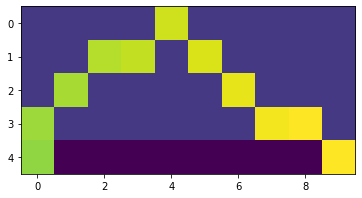

In [10]:
V    = n_step_td(cliff, 0.5, 2, 2000)
path = trace_V(cliff, V)
cliff.show_path(path)

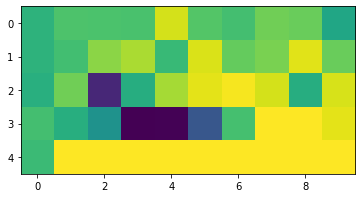

In [11]:
plt.imshow(V)

# n-Step SARSA

In [12]:
def epsilon_greedy_policy_Q(Q, map_, pos, epsilon=0.1):
    '''
    Q         : 3d np.array(), float : State-Action values
    map_      : Cliff                : Environment
    pos       : tuple(int, int)      : Position in Environment
    epsilon   : float in [0, 1]      : Exploration / Exploitation Parameter
    
    Epsilon Greedy Policy. For a low epsilon value : high exploitation, low exploration
    
              : tuple(int, int)      : Decided Action according to policy
    '''
    
    global moves
    
    act_i = None
    r     = np.random.rand()
        
    if r > epsilon:
        act_i = np.argmax(Q[pos])
    else:
        act_i = np.random.randint(len(moves))
        
    return moves[act_i]

In [13]:
def n_step_sarsa(map_, alpha, n, episodes, epsilon=0.1, gamma=1):
    '''
    alpha    : float in (0, 1]      : Learning rate
    n        : int                  : How many steps ahead we look
    episodes : int                  : Amount of episodes we train for
    epsilon  : float in [0, 1]      : Epsilon parameter for epsilon-greedy policy
    gamma    : float in [0, 1]      : Discount rate
     
    n-step temporal difference method to estimate V
    
    Q        : 3d np.array(), float : State-Action values
    '''
    
    global moves
    
    Q = np.zeros((map_.shapex, map_.shapey, len(moves)))
    
    for episode in range(episodes):
        t = 0
        s = map_.start
        
        T = np.inf
        S = [s]
        R = []
        A = [epsilon_greedy_policy_Q(Q, map_, s, epsilon=epsilon)]
        
        while True:
            # Take next step
            if t < T:
                sn, fallen = move(map_, s, A[-1])
                
                r = -1
                if fallen:
                    r = -100
                    
                if sn == map_.goal:
                    r = 0
                    T = t + 1
                else:
                    A.append(epsilon_greedy_policy_Q(Q, map_, sn, epsilon=epsilon))
                
                S.append(sn)
                R.append(r)
                s = sn
            
            # Time which will get updated this step 
            tau = t - n + 1
            
            # Update State Values
            if tau >= 0:
                
                G = sum([gamma**(i - tau - 1) * R[i] for i in range(tau + 1, min(tau + n, T))])
                
                if tau + n < T:
                    idx_tn = (S[tau + n][0], S[tau + n][1], move_idx[A[tau + n]])
                    G += gamma**n * Q[idx_tn]
                    
                idx_t = (S[tau][0], S[tau][1], move_idx[A[tau]])
                Q[idx_t] += alpha * (G - Q[idx_t])
            
            t += 1
            
            # Episode over
            if tau == T - 1:
                break
    
    return Q

In [14]:
def trace_Q(map_, Q):
    '''
    map_    : Cliff                 : Current environment
    Q       : 3d np.array(), float  : State-Action values
    
    Records Greedy Path from grid-start
    
    path    : list(tuple(int, int)) : States visited until termination
    '''
    
    global moves
    
    S = map_.start
    A = moves[np.argmax(Q[S])]
    path = []
    
    while S != map_.goal:
        path.append(S)
        Sn, _ = move(map_, S, A)
        An    = moves[np.argmax(Q[Sn])]
        S     = Sn
        A     = An
        
        if Sn == map_.start or Sn in path:
            print("State Values dont create greedy path")
            break
    
    return path

path length: 14


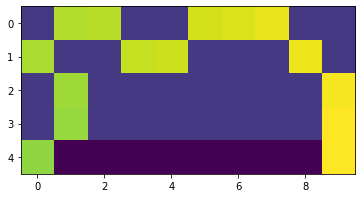

In [26]:
Q    = n_step_sarsa(cliff, 0.5, 2, 8000)
path = trace_Q(cliff, Q)
cliff.show_path(path)